# Assignment 12
Collaborative work by Adrian Bremer and Philipp Reinig

# Imports and Setup

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random

from mpl_toolkits.axes_grid1 import ImageGrid

# Loading the Dataset


In [24]:
dataset = np.load("data2.npz")
train_imgs = dataset["train_imgs"]
train_lbls = dataset["train_lbls"]
val_imgs = dataset["val_imgs"]
val_lbls = dataset["val_lbls"]
test_imgs = dataset["test_imgs"]
test_lbls = dataset["test_lbls"]

print(dataset)
print(type(dataset))
print(list(dataset.keys()))


NpzFile 'data2.npz' with keys: train_imgs, train_lbls, val_imgs, val_lbls, test_imgs...
<class 'numpy.lib.npyio.NpzFile'>
['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']


### Preprocessing

In [25]:
# Casting the data-type to float32
train_imgs = train_imgs.astype('float32')
test_imgs = test_imgs.astype('float32')
val_imgs = val_imgs.astype('float32')

train_lbls = train_lbls.astype('int32')
test_lbls = test_lbls.astype('int32')
val_lbls = val_lbls.astype('int32')

# Normalizing all values to the range [0.0, 1.0] -> they are already normalized
# train_imgs /= 255
# test_imgs /= 255
# val_imgs /= 255

### Checking the Dimensions of the Dataset

In [26]:
print(f"Training set: ")
print(f"\tDimensions of the images: {train_imgs.shape}")
print(f"\tDimensions of the labels: {train_lbls.shape}")

print(f"Validation set: ")
print(f"\tDimensions of the images: {val_imgs.shape}")
print(f"\tDimensions of the labels: {val_lbls.shape}")

print(f"Test set: ")
print(f"\tDimensions of the images: {test_imgs.shape}")
print(f"\tDimensions of the labels: {test_lbls.shape}")

Training set: 
	Dimensions of the images: (50000, 32, 32, 3)
	Dimensions of the labels: (50000,)
Validation set: 
	Dimensions of the images: (5000, 32, 32, 3)
	Dimensions of the labels: (5000,)
Test set: 
	Dimensions of the images: (10000, 32, 32, 3)
	Dimensions of the labels: (10000,)


### Taking a look at some Example Images as Numpy Arrays

In [27]:
for i in range(3):
  rand_indx = random.randint(0, len(train_imgs) - 1)
  print(f"Image {rand_indx}:")
  print(f"{train_imgs[rand_indx]}")


Image 39135:
[[[0.46666667 0.46666667 0.46666667]
  [0.32941177 0.32941177 0.32941177]
  [0.47058824 0.47058824 0.47058824]
  ...
  [0.43529412 0.43529412 0.43529412]
  [0.70980394 0.70980394 0.70980394]
  [0.6745098  0.6745098  0.6745098 ]]

 [[0.49803922 0.49803922 0.49803922]
  [0.3529412  0.3529412  0.3529412 ]
  [0.46666667 0.46666667 0.46666667]
  ...
  [0.4509804  0.4509804  0.4509804 ]
  [0.7176471  0.7176471  0.7176471 ]
  [0.6901961  0.6901961  0.6901961 ]]

 [[0.53333336 0.53333336 0.53333336]
  [0.38431373 0.38431373 0.38431373]
  [0.44313726 0.44313726 0.44313726]
  ...
  [0.4862745  0.4862745  0.4862745 ]
  [0.7254902  0.7254902  0.7254902 ]
  [0.7058824  0.7058824  0.7058824 ]]

 ...

 [[0.11764706 0.11764706 0.11764706]
  [0.27058825 0.27058825 0.27058825]
  [0.16078432 0.16078432 0.16078432]
  ...
  [0.5882353  0.5882353  0.5882353 ]
  [0.5529412  0.5529412  0.5529412 ]
  [0.50980395 0.50980395 0.50980395]]

 [[0.09019608 0.09019608 0.09019608]
  [0.1882353  0.1882353 

### Taking a Look at some Example Images

Image 17531:


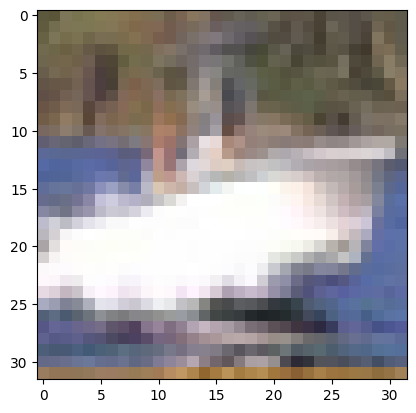

Image 41857:


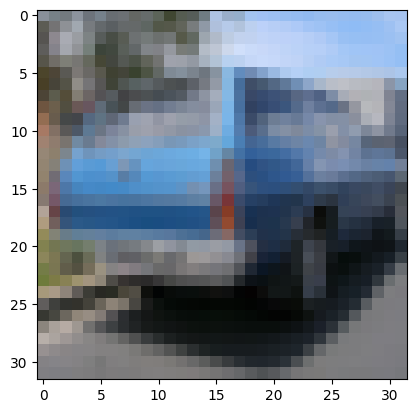

Image 32320:


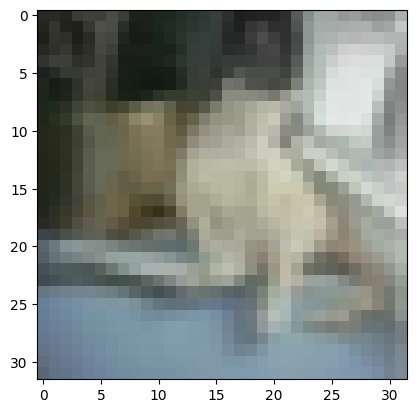

Image 48337:


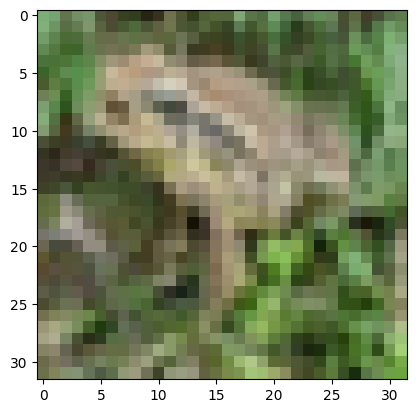

Image 25948:


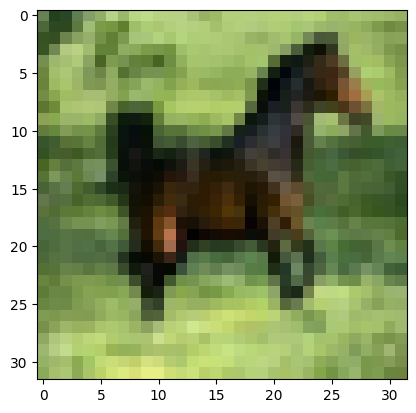

Image 12454:


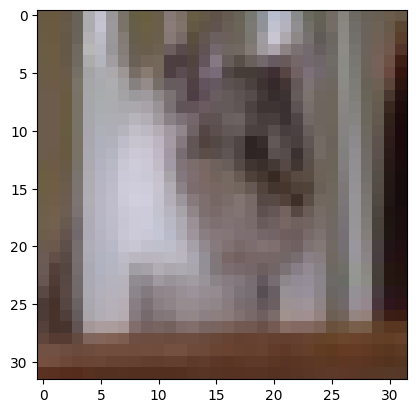

Image 18539:


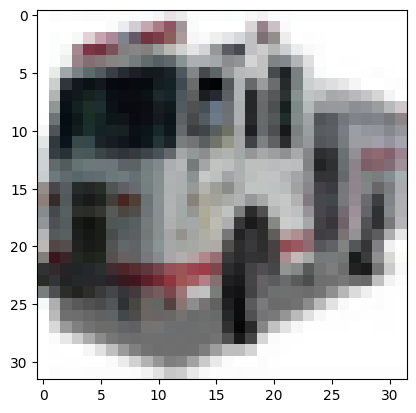

Image 32050:


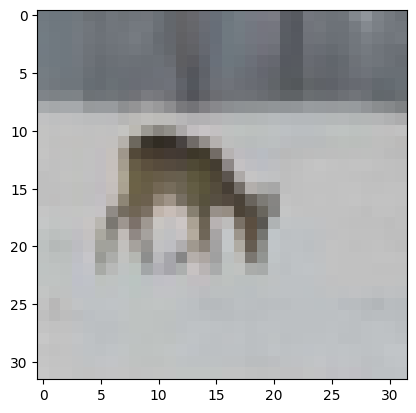

Image 8218:


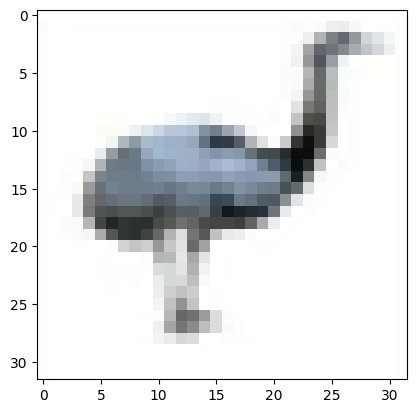

Image 11694:


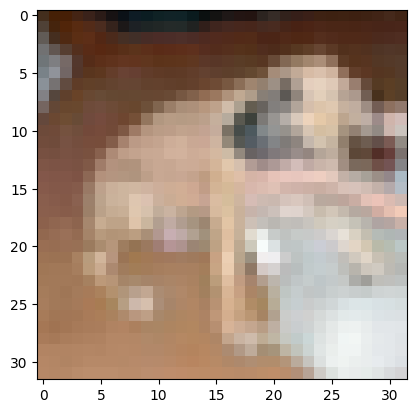

In [28]:
for i in range(10):
  rand_indx = random.randint(0, len(train_imgs) - 1)
  plt.imshow(train_imgs[rand_indx])
  print(f"Image {rand_indx}:")
  plt.show()

#  A Model for CIFAR-10

## Implementing the Model

In [29]:
class ResBlock(keras.Model):
  count = 1

  def __init__(self, filters, kernel_size):
    super().__init__(name="ResBlock_"+str(ResBlock.count))
    self.filters=filters
    self.kernel_size=kernel_size

    self.conv1 = keras.layers.Conv2D(filters, kernel_size, activation="relu", padding="same")
    self.bn1 = keras.layers.BatchNormalization()
    self.conv2 = keras.layers.Conv2D(filters, kernel_size, activation="relu", padding="same")
    self.add = keras.layers.Add()
    self.relu = keras.layers.ReLU()
    self.bn2 = keras.layers.BatchNormalization()

    ResBlock.count += 1

  def call(self, inputs):
    if inputs.shape[3] != self.filters:
      raise ValueError(f"Incompatible shape of x: ({inputs.shape}) and amount of filters: {self.filters}")

    x = tf.identity(inputs)
    x_initial = tf.identity(x)

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)

    x = self.add([x_initial, x])
    x = self.relu(x)
    x = self.bn2(x)

    return x

class ResBlockGroup(keras.Model):

  count = 1

  def __init__(self, n: int, filters: int, kernel_size: int):
    super().__init__(name="ResBlockGroup_" + str(ResBlockGroup.count))

    if n < 1:
      raise ValueError("n has to be at least 1")

    self.n = n
    self.filters = filters
    self.kernel_size = kernel_size

    self.res_blocks = [ResBlock(self.filters, self.kernel_size) for _ in range(self.n)]

    ResBlockGroup.count += 1


  def call(self, inputs):
    if inputs.shape[3] != self.filters:
      raise ValueError(f"Incompatible amount of filters and input shape")

    x = inputs

    for res_block in self.res_blocks:
      x = res_block(x)

    return x

  def get_functional_model(self):
    inputs = keras.Input(shape=(32,32,self.filters))

    return keras.Model(inputs=inputs, outputs=self.call(inputs))

class CiFar10ResNetModel(keras.Model):

  def __init__(self):
    super().__init__(name="CiFar10ResNetModel")

    self.res_block_group_1 = ResBlockGroup(3,3,3)
    self.res_block_group_2 = ResBlockGroup(3,6,3)
    self.resize_layer_1 = keras.layers.Conv2D(6,1, 2, padding="same")
    self.avg_pooling = keras.layers.AveragePooling2D(pool_size=2)
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(10, name="Dense")

  def build(self, input_shape):
    pass

  def call(self, input):

    x = self.res_block_group_1(input)
    x = self.resize_layer_1(x)
    x = self.res_block_group_2(x)
    x = self.avg_pooling(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x


  def get_functional_model(self) -> keras.Model:

    input = keras.Input(shape=(32,32,3))

    return keras.Model(inputs=input, outputs=self.call(input))



In [30]:
model = CiFar10ResNetModel().get_functional_model()

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [31]:
print(model.metrics_names)

[]


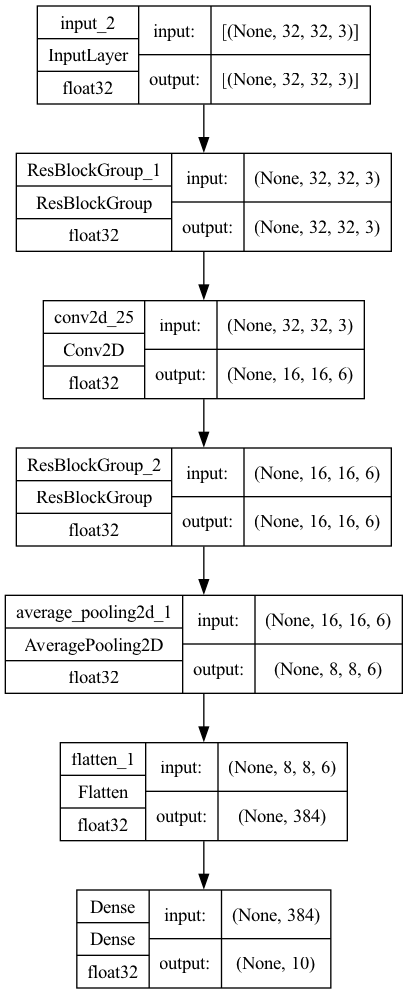

In [32]:
tf.keras.utils.plot_model(model, show_dtype=True, show_layer_names=True, show_shapes=True)

## Training

In [33]:
# Creating the datasets
batch_size = 512


train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls)).shuffle(len(train_lbls)).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((val_imgs, val_lbls)).shuffle(len(val_lbls)).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls)).shuffle(len(test_lbls)).batch(batch_size).repeat()



train_data_size = float('inf') if train_data.cardinality() == tf.data.INFINITE_CARDINALITY else len(train_data)
val_data_size = float('inf') if val_data.cardinality() == tf.data.INFINITE_CARDINALITY else len(val_data)
test_data_size = float('inf') if test_data.cardinality() == tf.data.INFINITE_CARDINALITY else len(test_data)

# Checking the sizes
print(f"Training dataset contains {train_data_size} batches with {batch_size} elements each -> {train_data_size * batch_size} total elements")
print(f"Validation dataset contains {val_data_size} batches with {batch_size} elements each -> {val_data_size * batch_size} total elements")
print(f"Test dataset contains {test_data_size} batches with {batch_size} elements each -> {test_data_size * batch_size} total elements")

Training dataset contains inf batches with 512 elements each -> inf total elements
Validation dataset contains inf batches with 512 elements each -> inf total elements
Test dataset contains inf batches with 512 elements each -> inf total elements


In [34]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_loss = []
test_acc = []

class EvaluationCallback (tf.keras.callbacks.Callback):

  def __init__(self, train_data_size_, val_data_size_, test_data_size_, batch_size_):
    super().__init__()
    self.train_data_size_ = train_data_size_
    self.val_data_size_ = val_data_size_
    self.test_data_size_ = test_data_size_
    self.batch_size_ = batch_size_


  def on_epoch_end(self, epoch, logs=None):
    print("")

    train_loss_, train_acc_ = self.model.evaluate(train_data, verbose=0, steps=self.train_data_size_)
    train_loss_ = round(train_loss_, 3)
    train_acc_ = round(train_acc_, 3)
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    print(f"\tTrain loss: {train_loss_}, Train accuracy {train_acc_}")

    val_loss_, val_acc_ = self.model.evaluate(val_data, verbose=0, steps=self.val_data_size_)
    val_loss_ = round(val_loss_, 3)
    val_acc_ = round(val_acc_, 3)
    val_loss.append(val_loss_)
    val_acc.append(val_acc_)
    print(f"\tValidation loss: {val_loss_}, Validation accuracy {val_acc_}")

    test_loss_, test_acc_ = self.model.evaluate(test_data, verbose=0, steps=self.test_data_size_)
    test_loss_ = round(test_loss_, 3)
    test_acc_ = round(test_acc_, 3)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    print(f"\tTest loss: {test_loss_}, Test accuracy {test_acc_}")


In [35]:
train_loss.clear()
train_acc.clear()
test_loss.clear()
test_acc.clear()

train_data_size_effective = train_imgs.shape[0]/batch_size if train_data_size == float('inf') else train_data_size
val_data_size_effective = val_imgs.shape[0]/batch_size if val_data_size == float('inf') else val_data_size
test_data_size_effective = test_imgs.shape[0]/batch_size if test_data_size == float('inf') else test_data_size


model.fit(train_data, epochs=10, steps_per_epoch=512, callbacks=[EvaluationCallback(train_data_size_effective, val_data_size_effective, test_data_size_effective, batch_size)])

Epoch 1/10
512/512 [==============================] - ETA: 0s - loss: 1.6341 - accuracy: 0.4109
	Train loss: 1.507, Train accuracy 0.454
	Validation loss: 1.503, Validation accuracy 0.462
	Test loss: 1.52, Test accuracy 0.443
512/512 [==============================] - 21s 38ms/step - loss: 1.6341 - accuracy: 0.4109
Epoch 2/10
512/512 [==============================] - ETA: 0s - loss: 1.3293 - accuracy: 0.5237
	Train loss: 1.259, Train accuracy 0.552
	Validation loss: 1.255, Validation accuracy 0.557
	Test loss: 1.315, Test accuracy 0.529
512/512 [==============================] - 18s 36ms/step - loss: 1.3293 - accuracy: 0.5237
Epoch 3/10
511/512 [============================>.] - ETA: 0s - loss: 1.1923 - accuracy: 0.5762
	Train loss: 1.148, Train accuracy 0.594
	Validation loss: 1.141, Validation accuracy 0.595
	Test loss: 1.214, Test accuracy 0.566
512/512 [==============================] - 19s 36ms/step - loss: 1.1921 - accuracy: 0.5763
Epoch 4/10
511/512 [===========================

In [36]:
model.save("my_model_1.keras")

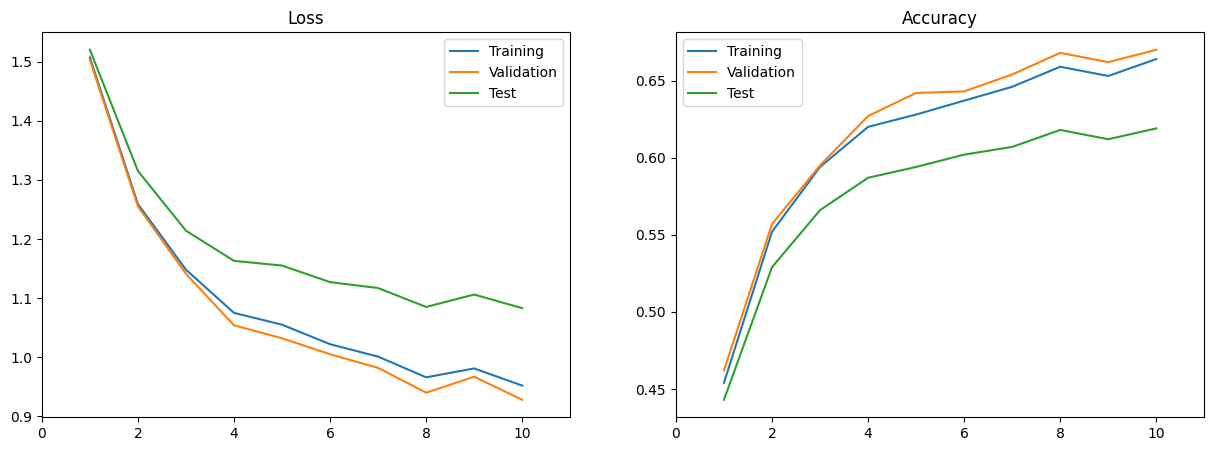

In [37]:
def plot_training_curves(train_loss_, train_acc_, val_loss_, val_acc_, test_loss_, test_acc_):
  epochs = len(train_loss_)
  x_lbls = np.arange(1, epochs+1)

  # print(f"Training loss: {train_loss_}")
  # print(f"Training accuracy: {train_acc_}")

  # print(f"Test loss: {test_acc_}")
  # print(f"Test accuracy: {test_acc_}")


  fig, (ax_loss, ax_acc) = plt.subplots(1,2, figsize=(15,5))
  train_loss_curve, = ax_loss.plot(x_lbls, train_loss_, label='Training')
  val_loss_curve, = ax_loss.plot(x_lbls, val_loss_, label='Validation')
  test_loss_curve, = ax_loss.plot(x_lbls, test_loss_, label='Test')
  ax_loss.legend(handles=[train_loss_curve, val_loss_curve, test_loss_curve])

  ax_loss.set_title("Loss")
  ax_loss.set_xlim(0, x_lbls[len(x_lbls)-1] + 1)

  train_acc_curve, = ax_acc.plot(x_lbls, train_acc_, label='Training')
  val_acc_curve, = ax_acc.plot(x_lbls, val_acc_, label='Validation')
  test_acc_curve, = ax_acc.plot(x_lbls, test_acc_, label='Test')
  ax_acc.legend(handles=[train_acc_curve, val_acc_curve, test_acc_curve])

  ax_acc.set_title("Accuracy")
  ax_acc.set_xlim(0, x_lbls[len(x_lbls)-1] + 1)

  plt.show()

plot_training_curves(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)

# Computing Statistics of the Dataset

### Label Distribution

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
{0: 493, 1: 488, 2: 479, 3: 519, 4: 475, 5: 529, 6: 488, 7: 485, 8: 532, 9: 512}
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


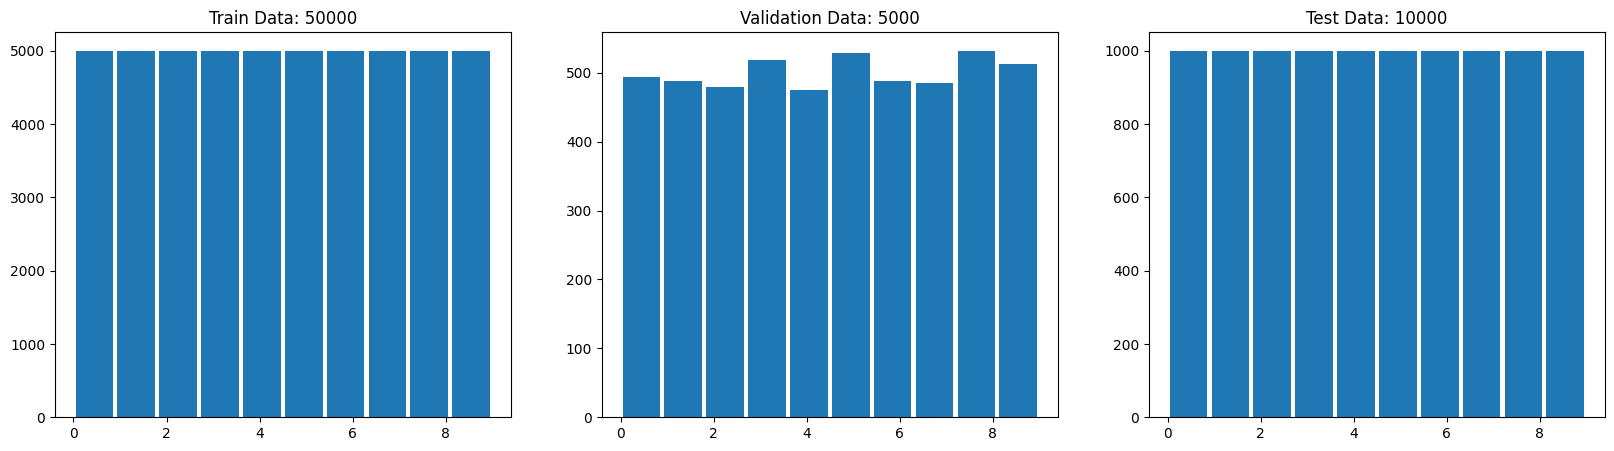

In [42]:
def calc_distribution(lbls):
    dict = {}
    for lbl in lbls:
        if lbl in dict.keys():
            dict[lbl] += 1
        else:
            dict[lbl] = 1

    return dict

def plot_distributions(train_lbls_, val_lbls_, test_lbls_):
    x_lbls = np.arange(0, 9)

    # train_dist_vals = [train_dist[indx] for indx in x_lbls if indx in train_dist.keys() else 0]

    fig, (ax_train, ax_val, ax_test) = plt.subplots(1,3, figsize=(20,5))
    
    ax_train.hist(train_lbls_, rwidth=0.9)
    ax_train.set_title(f"Train Data: {len(train_imgs)}")

    ax_val.hist(val_lbls, rwidth=0.9)
    ax_val.set_title(f"Validation Data: {len(val_imgs)}")

    ax_test.hist(test_lbls_, rwidth=0.9)
    ax_test.set_title(f"Test Data: {len(test_imgs)}")

train_dist = dict(sorted(calc_distribution(train_lbls).items()))
val_dist = dict(sorted(calc_distribution(val_lbls).items()))
test_dist = dict(sorted(calc_distribution(test_lbls).items()))

plot_distributions(train_lbls, val_lbls, test_lbls)


print(train_dist)
print(val_dist)
print(test_dist)

### Image/Value Distribution

In [ ]:
print(f"Training values range: {np.min(train_imgs)} -> {np.max(train_imgs)}")
print(f"Validiation values range: {np.min(val_imgs)} -> {np.max(val_imgs)}")
print(f"Test values range: {np.min(test_imgs)} -> {np.max(test_imgs)}")


### Checking for Duplicates within the Dataset

In [ ]:
def find_duplicates(arr):
    elems, counts = np.unique(arr, return_counts=True, axis=0)
    del_mask = [True if count == 1 else False for count in counts]
    elems = np.delete(elems, del_mask, axis=0)
    counts = np.delete(counts, del_mask, axis=0)

    return elems, counts

def plot_duplicates(imgs, counts):
    n = min(len(imgs), 25)
    sqrt_n = int(np.ceil(np.sqrt(n)))

    fig, axs = plt.subplots(sqrt_n, sqrt_n, figsize=(10, 10))

    for i in range(sqrt_n):
        for j in range(sqrt_n):
            if sqrt_n*i+j < n:
                axs[i, j].imshow(imgs[sqrt_n*i+j])
                axs[i, j].set_title(f"Duplicates: {counts[sqrt_n*i+j]}")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()


img_sets = [train_imgs, val_imgs, test_imgs]
ttl_lbls = ["Training", "Validation", "Test"]

for img_set, ttl_lbl in zip(img_sets, ttl_lbls):
    dups, counts = find_duplicates(img_set)
    if len(dups) > 0:
        print(f"{ttl_lbl} contains {len(dups)} duplicate images")
        plot_duplicates(dups, counts)
    else: 
        print(f"{ttl_lbl} does not contain any duplicate images")

### Checking if Dataset Splits are disjunct

In [ ]:
train_imgs_unique = np.unique(train_imgs, axis=0)
val_imgs_unique = np.unique(val_imgs, axis=0)
test_imgs_unique = np.unique(test_imgs, axis=0)

print(f"{len(train_imgs_unique)}")
print(f"{len(val_imgs_unique)}")
print(f"{len(test_imgs_unique)}")


train_val_imgs = np.concatenate((train_imgs_unique, val_imgs_unique))
train_test_imgs = np.concatenate((train_imgs_unique, test_imgs_unique))
val_test_imgs = np.concatenate((val_imgs_unique, test_imgs_unique))

img_sets_concated = [train_imgs_unique, val_imgs_unique, test_imgs_unique]
ttl_lbls_concated = ["Training_Validation", "Training_Test", "Validation_Test"]

for img_set, ttl_lbl in zip(img_sets_concated, ttl_lbls_concated):
    dups, counts = find_duplicates(img_set)
    if len(dups) > 0:
        print(f"{ttl_lbl} contains {len(dups)} duplicate images")
        plot_duplicates(dups, counts)
    else: 
        print(f"{ttl_lbl} does not contain any duplicate images")



# Findings
### Dataset 1
- Accuracy on the test set is way below accuracy on training and validation set
- Training and validation set is missing data with labels 3 and 7 which is included in the test set

### Dataset 2
- Everything looks fine
- Performance on the test set is around 5% worse than on the training set, which isn't too bad though
- However, the model hasn't been trained on both the validation and test set and it performs significantly better on the validation set
- This hints that here has to be a difference between the validation and test set. I could think of the following possibilites:
    - The validation and test set are from different distributions
    - There are more wrong annotations in the test set compared to the validation set
    - There are no duplicates in either of the splits and they are disjunct -> this can't be an issue


### Dataset 3
- Reasonable performance on the training and validation set
- The performance on the test set is horrible - less than 20%
- The test set contains values in invalid range: -1 to 1, instead of 0 to 1

### Dataset 4
- Training and validation accuracy are quickly at 100%, but test performance is horrible
- Training and validation set contain just a single image for each category, but test set contains different contains a lot only different images
- The model just remembers the images of the training and validation set, but doesn't generalize to perform well on the test set